<a href="https://colab.research.google.com/github/sgerloff/fashion_one_shot_test/blob/main/google_colab/explore_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get connection to google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf /content/fashion_one_shot_test
!git clone https://github.com/sgerloff/fashion_one_shot_test.git
!chmod +x /content/fashion_one_shot_test/google_colab_utility/*.sh
!/content/fashion_one_shot_test/google_colab_utility/setup_train_data.sh

Streaming output truncated to the last 5000 lines.
  inflating: train/image_cat1/014774_1186.jpg  
  inflating: train/image_cat1/014761_1185.jpg  
  inflating: train/image_cat1/014729_1181.jpg  
  inflating: train/image_cat1/014810_1188.jpg  
  inflating: train/image_cat1/014720_1181.jpg  
  inflating: train/image_cat1/014744_1183.jpg  
  inflating: train/image_cat1/014871_1195.jpg  
  inflating: train/image_cat1/014713_1181.jpg  
  inflating: train/image_cat1/014859_1195.jpg  
  inflating: train/image_cat1/014870_1195.jpg  
  inflating: train/image_cat1/014706_1180.jpg  
  inflating: train/image_cat1/014711_1180.jpg  
  inflating: train/image_cat1/014714_1181.jpg  
  inflating: train/image_cat1/014857_1195.jpg  
  inflating: train/image_cat1/014863_1195.jpg  
  inflating: train/image_cat1/014737_1181.jpg  
  inflating: train/image_cat1/014806_1188.jpg  
  inflating: train/image_cat1/014721_1181.jpg  
  inflating: train/image_cat1/014804_1188.jpg  
  inflating: train/image_cat1/014767_

Now we can read our database again:

In [12]:
from fashion_one_shot_test.google_colab_utility.get_train_database import get_clean_database
df = get_clean_database("/content/drive/MyDrive/deepfashion2/category_id_1_deepfashion_train.joblib")

Contains 663 entries with unique pair_id, which we will drop.


In [17]:
import os
image_folder = "train/image_cat1"
df["image"] = df["image"].apply(lambda x: os.path.join(image_folder, x.split("\\")[-1]))

If we want to read a saved model, we need to do the following:

In [3]:
!(cp /content/drive/MyDrive/deepfashion2/triplet_deepfashion.h5 .)

In [14]:
from fashion_one_shot_test.mean_l2_distance_ratio_metric import mean_l2_distance_ratio_metric
from fashion_one_shot_test.triplet_batch import TripletBatch
import tensorflow as tf
import tensorflow_addons as tfa

In [11]:
dependencies = {
    'custom_metric': mean_l2_distance_ratio_metric
}
model = tf.keras.models.load_model("triplet_deepfashion.h5", custom_objects=dependencies)

In [27]:
resolution=224
triplet_batch = TripletBatch(df, resolution)
np.sum(model.predict( tf.reshape(triplet_batch.get_array_for_item(df.index[0]), (1,224,224,3)) ))

1.0

I have already computed the embeddings for all the examples:

In [19]:
!(cp /content/drive/MyDrive/deepfashion2/trained_embeddings.joblib .)

In [21]:
import joblib
embeddings = joblib.load("trained_embeddings.joblib")

In [28]:
np.sum(embeddings[7835])

1.0000002

In [23]:
import pandas as pd
df["embedding"] = pd.Series(embeddings, index=df.index)

We can now demonstrate how bad this model works currently and motivate changes in the metric and maybe tuning of the loss-function

In [55]:
from PIL import Image
import numpy as np

1.8858383555198088e-05 Int64Index([265501], dtype='int64')
0.023386327549815178 Int64Index([95642], dtype='int64')
1.8858383555198088e-05 Int64Index([265501], dtype='int64')
Images in order: Anchor, Global minimal distance, maximum positive distance, minimum negative distance


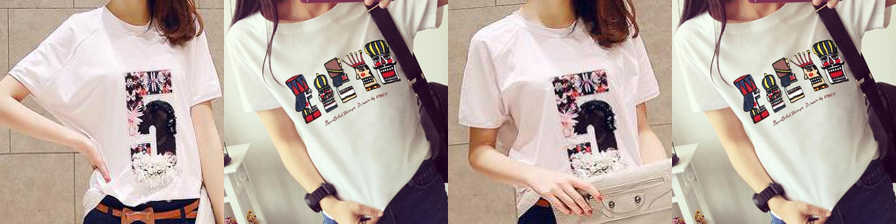

In [73]:
anchor = df.sample(1)
a_pair_id = anchor["pair_id"].values[0]

global_diffs = df["embedding"].drop(index=anchor.index).apply(lambda x: np.linalg.norm(x -anchor["embedding"].values[0] ))
print(global_diffs.min(), global_diffs[global_diffs == global_diffs.min()].index )

positive_diffs = df[df["pair_id"] == a_pair_id]["embedding"].apply(lambda x: np.linalg.norm(x - anchor["embedding"].values[0]))
print(positive_diffs.max(), positive_diffs[positive_diffs == positive_diffs.max()].index )

negative_diffs = df[df["pair_id"] != a_pair_id]["embedding"].apply(lambda x: np.linalg.norm(x - anchor["embedding"].values[0]))
print(negative_diffs.min(), negative_diffs[negative_diffs == negative_diffs.min()].index )



img_a = Image.open(anchor["image"].values[0]).resize((224,224))
img_g = Image.open( df.loc[global_diffs[global_diffs == global_diffs.min()].index, "image"].values[0] ).resize((224,224))
img_p = Image.open( df.loc[positive_diffs[positive_diffs == positive_diffs.max()].index, "image"].values[0] ).resize((224,224))
img_n = Image.open( df.loc[negative_diffs[negative_diffs == negative_diffs.min()].index, "image"].values[0] ).resize((224,224))

print("Images in order: Anchor, Global minimal distance, maximum positive distance, minimum negative distance")
Image.fromarray(np.hstack((np.array(img_a),np.array(img_g), np.array(img_p), np.array(img_n))))